In [1]:
#Today:
#nLeptons plot is weird -- now better before cuts?

#WZ background vs WZZ, mT for WZ, the remaining lepton from WZZ after indexing (i.e. identification for the invariant mass), the W candidate lepton! -- understand better

#scale the x axis better
#find the normalization factor for ZZ -- done
#Fiducial cross section is the one after the cuts
#el_eta plot weird after delR cut
#WZ number after the cuts, number bad. #Figure out why WZ number so bad after the ==3 cut.
#Add features, have a good story, also for the >=4lep - simple variables like sum of transverse momenta for jet and lepton
#Z candidate mass
#Leading sub leading second leading lepton momentum. 

#plot sub leading and third leading distributions before after cut


#sub leading lepton plots, 

#If time allows, do the same for 4leps, 
#Engineered variables would be different for >=4 case

# Data Loading and Preprocessing

In [1]:
#File Load Resetter
import importlib
import features_and_functions  # or whatever your .py file is named
importlib.reload(features_and_functions)

<module 'features_and_functions' from '/users/dbhandari/WZZtest/features_and_functions.py'>

In [2]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns
import os
import vector 
import numpy as np
import copy
import pandas as pd
import sys
sys.path.append('.')  #this adds current directory to path if not already
from features_and_functions import delta_r, invariant_mass, compute_invariant_mass_3lep, mt_nonZ_lepton_MET, compute_delta_phi_Z_lep
from features_and_functions import transverse_mass, compute_event_shapes, compute_mt, compute_deltaR_3lep, z_met_balance_features
from features_and_functions import compute_best_z_candidate_masses, extract_features, clean_leptons, compute_delta_phi_Z_MET
from features_and_functions import compute_thrust, compute_event_shapes_exact, total_event_et, compute_best_z_candidate_pt
from features_and_functions import compute_pairwise_masses_3lep, compute_delta_eta_phi_3lep, compute_pt_3lepsys, compute_dphi_met_3lepsys
import features_and_functions
print(dir(features_and_functions))

sns.set(style="whitegrid")

branches = [
    'el_pt', 'el_phi', 'el_eta', 'el_charge', 'nElectrons',
    'mu_pt', 'mu_phi', 'mu_eta', 'mu_charge', 'nMuons',
    'jet_pt', 'jet_phi', 'jet_eta', 'jet_mass', 'nJets',
    'jet_btag', 'MET', 'MET_Phi'
]

#loaading files
#wh_file = "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WH_HToZZ_pythia8_events.root"
wh_file = "/users/dbhandari/WZZAnalysisFiles/AnalysisTrees_WH_HToZZ_pythia8_events_All.root"

wzz_file = "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WZZ_3leptons_ZUndecayed.root"
background_files = [
    "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WZ_3lep_pythia8_events.root",
    "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_ZZ_pythia8_events.root"
]

#Or in a better way:
file_paths = {
    "WH": "/users/dbhandari/WZZAnalysisFiles/AnalysisTrees_WH_HToZZ_pythia8_events_All.root",
    "WZZ": "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WZZ_3leptons_ZUndecayed.root",
    "WZ": "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_WZ_3lep_pythia8_events.root",
    "ZZ": "/users/dbhandari/WZZAnalysisFiles/AnalysisTree_ZZ_pythia8_events.root"
}


def load_tree(file_path, branches):
    with uproot.open(file_path) as f:
        if file_path == wh_file:
            tree = f["PolarizationTree"]
        else:
            tree = f["LowPtSUSY_Tree"]
        return tree.arrays(branches, library="ak")

#loading signal and background data
signal_data = {
    "WH": load_tree(wh_file, branches),
    "WZZ": load_tree(wzz_file, branches),
}

background_data = {
    "WZ": load_tree(background_files[0], branches),
    "ZZ": load_tree(background_files[1], branches),
}

#need output directory for plots
output_dir = "plots_normalized"
os.makedirs(output_dir, exist_ok=True)

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'ak', 'behavior', 'clean_leptons', 'compute_4lep_masses_5lep', 'compute_best_z_candidate_masses', 'compute_best_z_candidate_masses_4lep', 'compute_best_z_candidate_pt', 'compute_deltaR_3lep', 'compute_deltaR_4lep', 'compute_deltaR_5lep', 'compute_delta_eta_phi_3lep', 'compute_delta_eta_phi_4lep', 'compute_delta_eta_phi_5lep', 'compute_delta_phi_Z_MET', 'compute_delta_phi_Z_lep', 'compute_delta_phi_between_Zs', 'compute_dphi_met_3lepsys', 'compute_dphi_met_4lepsys', 'compute_dphi_met_5lepsys', 'compute_event_shapes', 'compute_event_shapes_exact', 'compute_invariant_mass_3lep', 'compute_invariant_mass_4lep', 'compute_invariant_mass_5lep', 'compute_mt', 'compute_mt_4l', 'compute_mt_5l', 'compute_pairwise_masses_3lep', 'compute_pairwise_masses_4lep', 'compute_pairwise_masses_5lep', 'compute_pt_3lepsys', 'compute_pt_4lepsys', 'compute_pt_5lepsys', 'compute_thrust', 'compute_triplet_mas

## Making normalized plots of variables

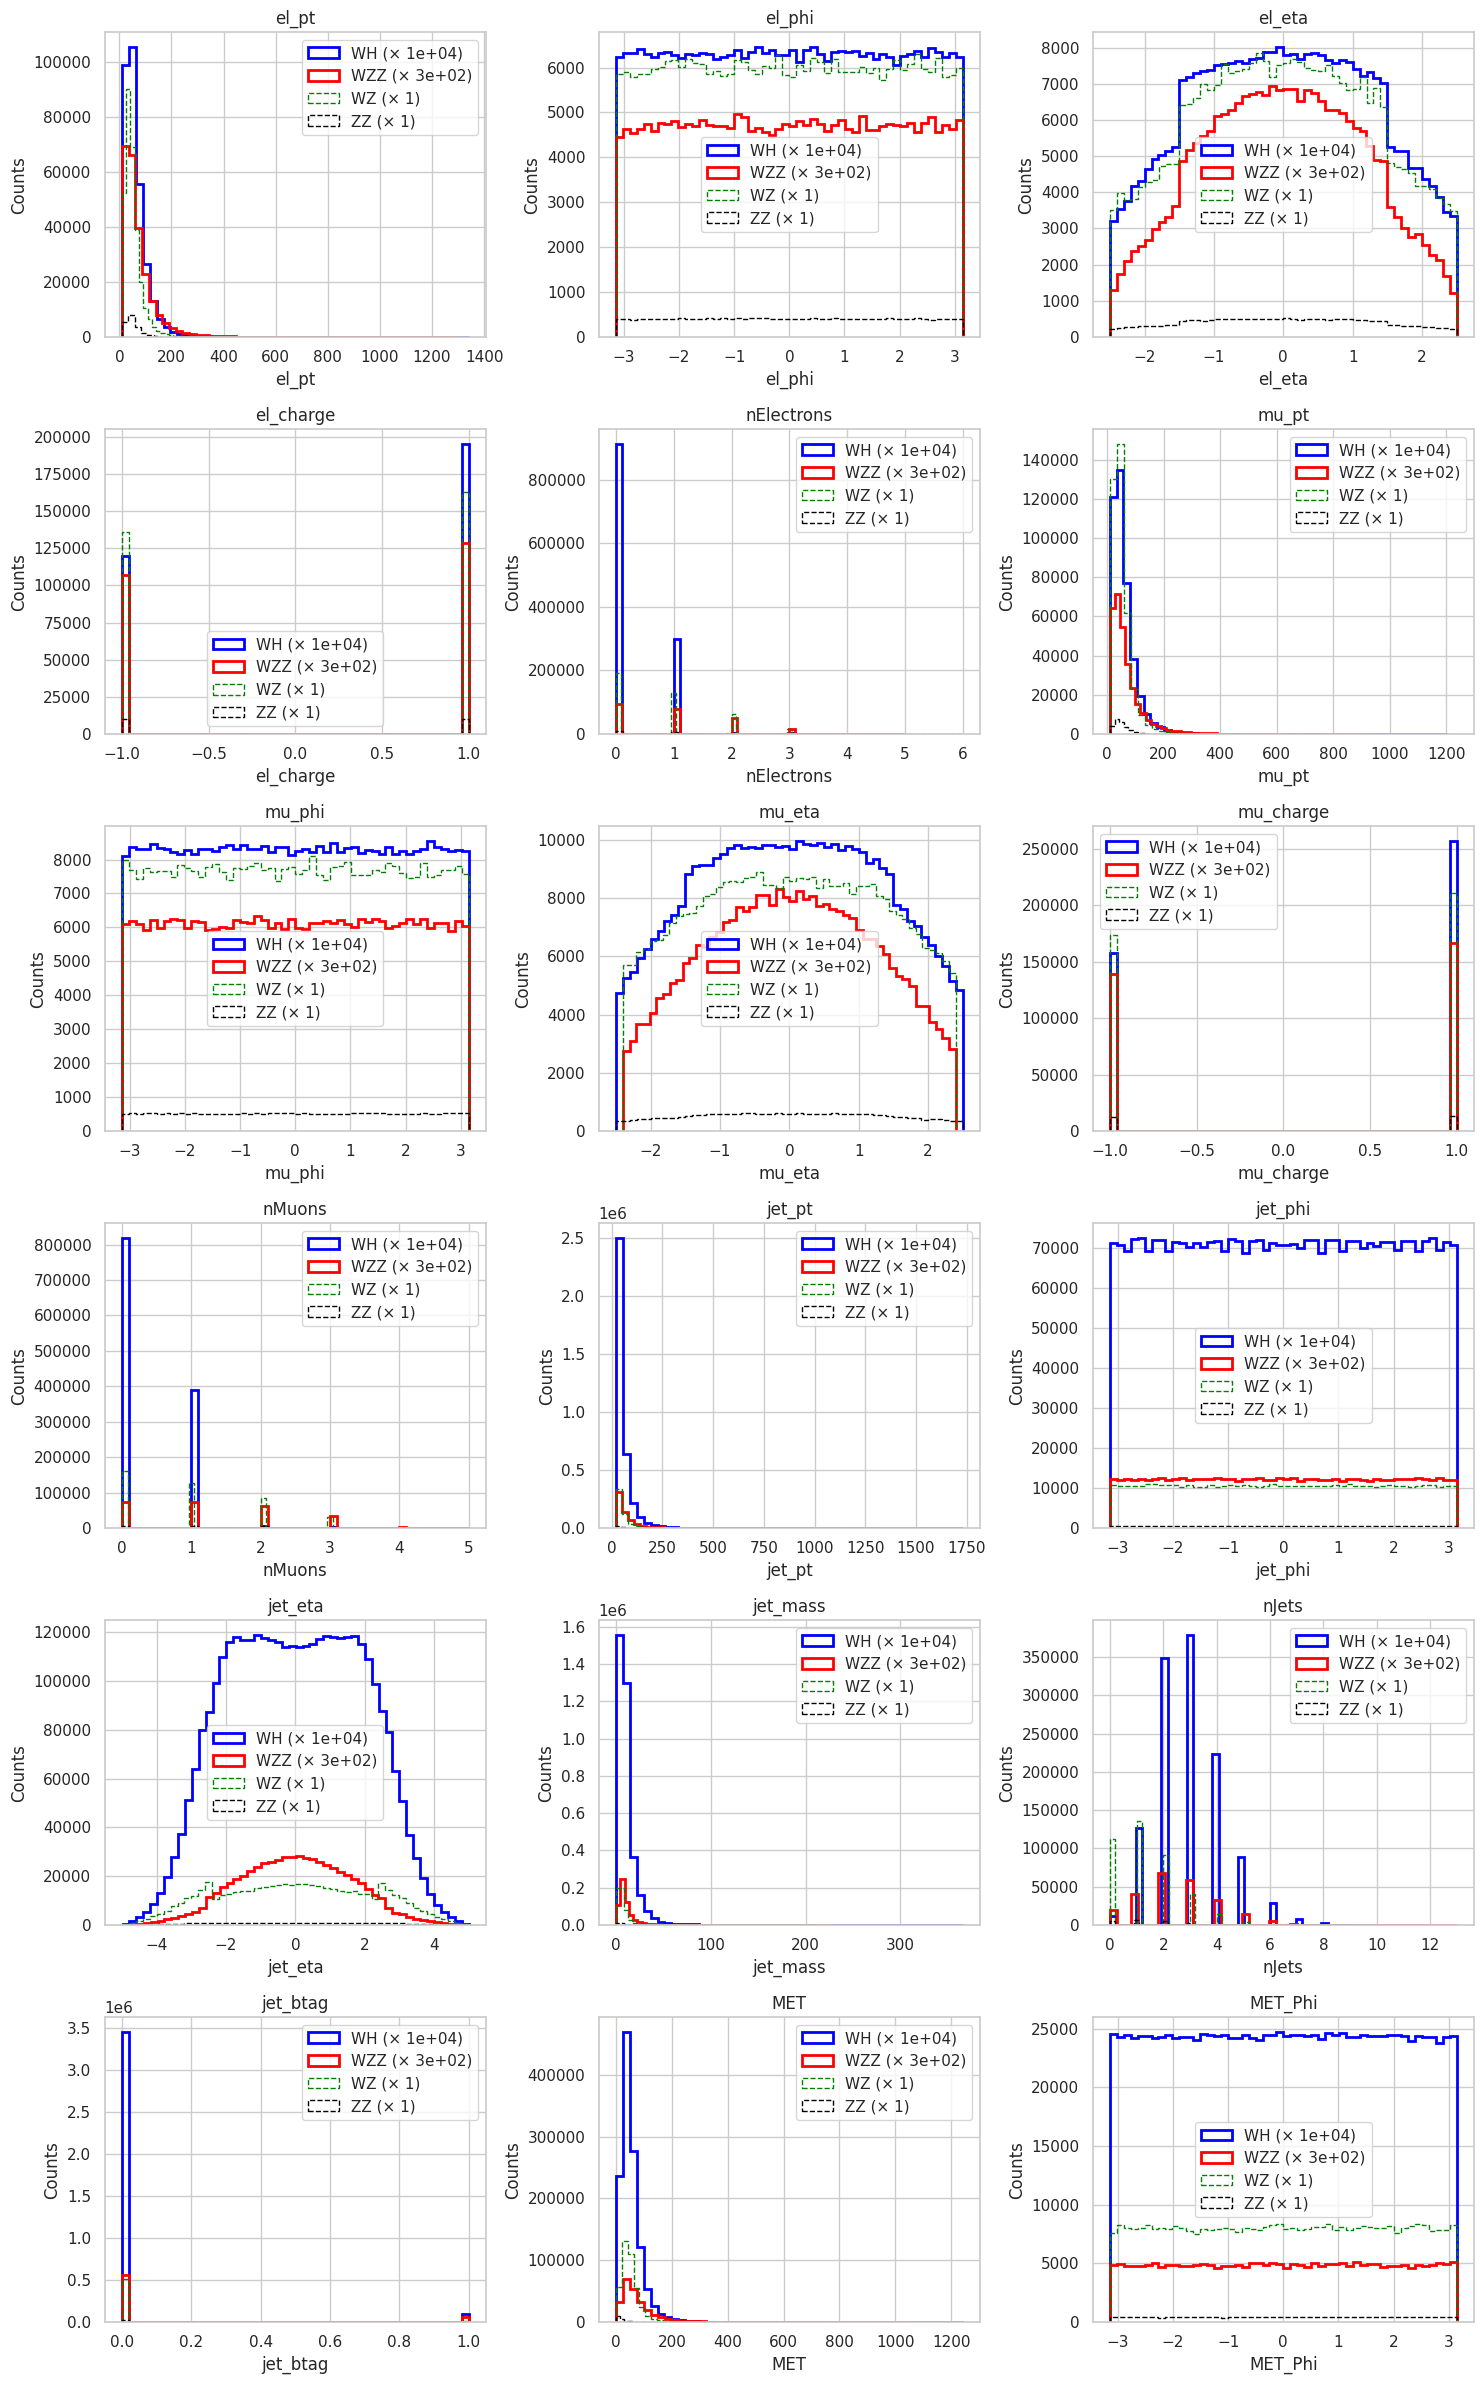

In [4]:
signal_colors = {
    "WH": "blue",
    "WZZ": "red",
}                                  #defining only once for sanity
background_colors = {
    "WZ": "green",
    "ZZ": "black",
}
all_colors = {**signal_colors, **background_colors}

norm_factors = {
    "WH": 0.0001218 * 10000,
    "WZZ": 0.0081 * 300,
    "WZ": 4.0,
    "ZZ": 0.196   #Why 4? New value used
}

multiplicative_factors = {
    "WH": 10000,
    "WZZ": 300,
    "WZ": 1.0,
    "ZZ": 1.0
}

n_cols = 3
n_rows = int(np.ceil(len(branches) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))   #plot layout
axes = axes.flatten()

for i, var in enumerate(branches):
    ax = axes[i]             #main loop for plot

    #sig
    for label, arr in signal_data.items():
        values = ak.flatten(arr[var], axis=None)
        weight = norm_factors[label]
        multiplier = multiplicative_factors[label]
        display_label = f"{label} (× {multiplier:.2g})"
        ax.hist(
            values,
            bins=50,
            histtype='step',
            linewidth=2,
            density=False,
            label=display_label,
            linestyle='-',
            color=signal_colors[label],
            weights=[weight] * len(values)
        )

    #backg
    for label, arr in background_data.items():
        values = ak.flatten(arr[var], axis=None)
        weight = norm_factors[label]
        multiplier = multiplicative_factors[label]
        display_label = f"{label} (× {multiplier:.2g})"
        ax.hist(
            values,
            bins=50,
            histtype='step',
            linewidth=1,
            density=False,
            label=display_label,
            linestyle='--',
            color=background_colors[label],
            weights=[weight] * len(values)
        )

    ax.set_xlabel(var)
    ax.set_ylabel("Counts")
    ax.set_title(f"{var}")
    ax.legend()

#if statements within the plotter can easily scale the x axis for specific plots

for j in range(len(branches), len(axes)):   #get rid of unused subplots
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("Combined_normalized.png")
plt.show()

## Leading lepton features

In [5]:
vars_to_print = ['el_pt', 'mu_pt']
for var in vars_to_print:
    print(f"{var}:")
    print("for WH:")
    print(signal_data["WH"][var][:10]) 
    print("for WZZ:")
    print(signal_data["WZZ"][var][:10])
    print("for WZ:")
    print(background_data["WZ"][var][:10])
    print("for ZZ:")
    print(background_data["ZZ"][var][:10])
     #first 10 entries for each file
    print()

#looks like they're sorted out for each event already,
# For leading particles, we can sort and take the first one
def leading_particle(arr):
    if len(arr) == 0:
        return None
    sorted_arr = ak.sort(arr, ascending=False)
    return sorted_arr[0] if len(sorted_arr) > 0 else None   

#printing leading particles,            #This will print the leading particle ONLY FOR THE FIRST EVENT, NOT USEFUL FOR ALL EVENTS
# we could modify it to print the leading particle for each event
print("Leading particles:")
for var in vars_to_print:
    print(f"{var}:")
    print("for WH:")
    print(leading_particle(signal_data["WH"][var]))
    print("for WZZ:")
    print(leading_particle(signal_data["WZZ"][var]))
    print("for WZ:")
    print(leading_particle(background_data["WZ"][var]))
    print("for ZZ:")
    print(leading_particle(background_data["ZZ"][var]))
    print()

def get_leading(values):
    try:
        return ak.to_numpy(ak.firsts(values))
    except Exception:
        return ak.to_numpy(values)



el_pt:
for WH:
[[49.9], [], [], [21.3], [], [], [51.5], [], [], []]
for WZZ:
[[], [], [], [], ..., [406], [89.2, 55.5, 30.3], [66.2], [56.6, 35.1, 28.6]]
for WZ:
[[84.6, 23.1], [114, 94.3], [], [], ..., [], [53.2, 37.6], [], [90.4, 22.8]]
for ZZ:
[[], [20.3], [], [], ..., [57.9, 13.8], [107, 27.2], [99.1, 59.9, 38.9, 34.7]]

mu_pt:
for WH:
[[], [], [], [], [], [20.3], [], [38.2], [], []]
for WZZ:
[[63.4], [93.5, 43.2, 40.4], [76.8], [268], [], [44.9], [25], [], [], []]
for WZ:
[[76.4], [], [20.1], [], [], [58], [58.2], [], [17.8], []]
for ZZ:
[[85.9], [87.9, 81], [26.3], [], [47.5, 42.8, ..., 21.5], ..., [], [], [], []]

Leading particles:
el_pt:
for WH:
[49.9]
for WZZ:
[]
for WZ:
[84.6, 23.1]
for ZZ:
[]

mu_pt:
for WH:
[]
for WZZ:
[63.4]
for WZ:
[76.4]
for ZZ:
[85.9]



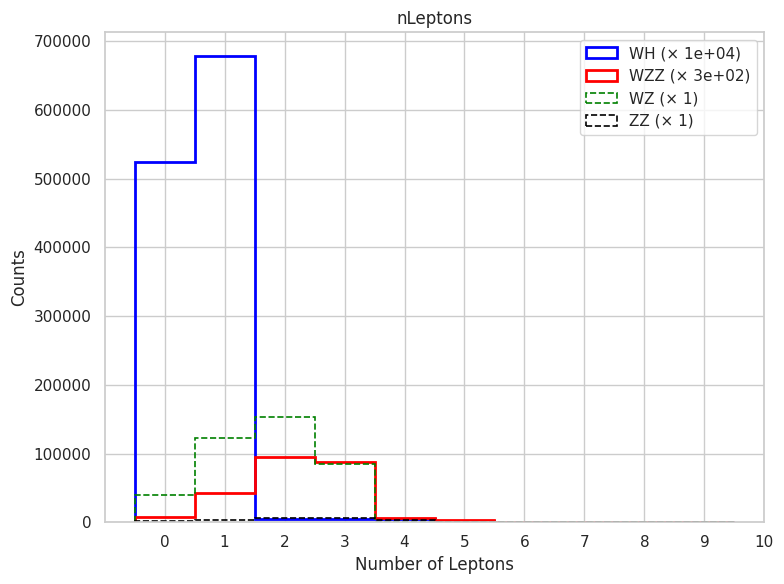

In [6]:
# Colors and factors from Part I
lepton_counts = {}

# Count leptons for signals
for label, arr in signal_data.items():
    n_electrons = ak.num(arr["el_pt"])
    n_muons = ak.num(arr["mu_pt"])
    lepton_counts[label] = ak.to_numpy(n_electrons + n_muons)

# Count leptons for backgrounds
for label, arr in background_data.items():
    n_electrons = ak.num(arr["el_pt"])
    n_muons = ak.num(arr["mu_pt"])
    lepton_counts[label] = ak.to_numpy(n_electrons + n_muons)
    
plt.figure(figsize=(8, 6))
bins = np.arange(0, 10 + 1) - 0.5  # center bins on integer values

for label, nlep in lepton_counts.items():
    weight = norm_factors[label]
    multiplier = multiplicative_factors[label]
    display_label = f"{label} (× {multiplier:.2g})"

    if label in signal_colors:
        color = signal_colors[label]
        linestyle = '-'
        linewidth = 2
    else:
        color = background_colors[label]
        linestyle = '--'
        linewidth = 1.2

    plt.hist(
        nlep,
        bins=bins,
        alpha=1,
        label=display_label,
        histtype='step',
        color=color,
        linewidth=linewidth,
        linestyle=linestyle,
        weights=[weight] * len(nlep)
    )

plt.xlabel("Number of Leptons")
plt.ylabel("Counts")
plt.title("nLeptons")
plt.xticks(np.arange(0, 11))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("nLeptons_normalized.png")
plt.show()


#Why does WH fall off after 1? 

### Plotting del_R before applying any cut

Loading WH...
Loading WZZ...
Loading WZ...
Loading ZZ...


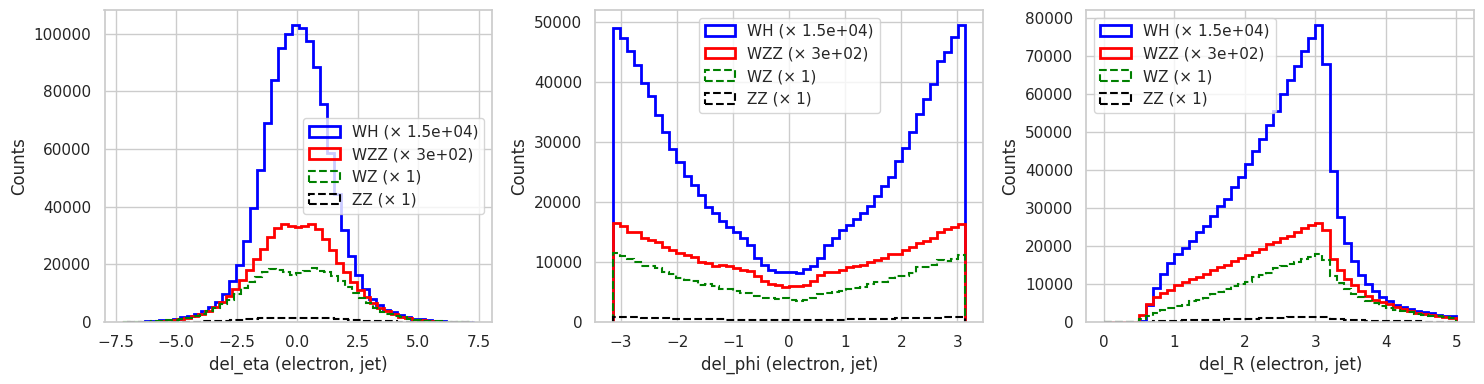

In [7]:
# label mapping for your files (adjust keys to match file_paths keys)
label_map = {0: "WH", 1: "WZZ", 2: "WZ", 3: "ZZ"}
colors = {0: "blue", 1: "red", 2: "green", 3: "black"}

# Normalization factors and multiplicative factors
norm_factors = {
    "WH": 0.0001218 * 15000,
    "WZZ": 0.0081 * 300,
    "WZ": 4.0,
    "ZZ": 0.196
}
multiplicative_factors = {
    "WH": 15000,
    "WZZ": 300,
    "WZ": 1.0,
    "ZZ": 1.0
}

signal_labels = {0, 1}  # WH and WZZ
background_labels = {2, 3}  # WZ and ZZ

# plotting containers for all datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# function to compute delta phi wrapped to [-pi, pi]
def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    return (dphi + np.pi) % (2 * np.pi) - np.pi

# loop over all files and plot
for label_val, (key, path) in enumerate(file_paths.items()):
    print(f"Loading {key}...")
    events = load_tree(path, branches)

    # zip electron and jet into convenient objects
    events["el"] = ak.zip({"eta": events.el_eta, "phi": events.el_phi})
    events["jet"] = ak.zip({"eta": events.jet_eta, "phi": events.jet_phi})

    # all el-jet pairs
    el_jet_pairs = ak.cartesian({"el": events.el, "jet": events.jet}, axis=1)

    #three dels
    delta_eta_el_jet = el_jet_pairs["el"].eta - el_jet_pairs["jet"].eta
    delta_phi_el_jet = delta_phi(el_jet_pairs["el"].phi, el_jet_pairs["jet"].phi)
    deltaR_el_jet = np.sqrt(delta_eta_el_jet**2 + delta_phi_el_jet**2)

    # flatten to 1D
    all_delta_eta = ak.to_numpy(ak.flatten(delta_eta_el_jet, axis=None))
    all_delta_phi = ak.to_numpy(ak.flatten(delta_phi_el_jet, axis=None))
    all_deltaR = ak.to_numpy(ak.flatten(deltaR_el_jet, axis=None))

    # style + weight
    label_name = label_map[label_val]
    weight = norm_factors[label_name]
    multiplier = multiplicative_factors[label_name]
    display_label = f"{label_name} (× {multiplier:.2g})"
    linestyle = '-' if label_val in signal_labels else '--'
    linewidth = 2 if label_val in signal_labels else 1.5

    # plot all three histograms
    axes[0].hist(all_delta_eta, bins=50, histtype="step",
                 color=colors[label_val], weights=np.full(len(all_delta_eta), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)
    axes[1].hist(all_delta_phi, bins=50, histtype="step",
                 color=colors[label_val], weights=np.full(len(all_delta_phi), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)
    axes[2].hist(all_deltaR, bins=50, range=(0, 5), histtype="step",
                 color=colors[label_val], weights=np.full(len(all_deltaR), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)

# label axes
axes[0].set_xlabel(r"del_eta (electron, jet)")
axes[0].set_ylabel("Counts")
axes[1].set_xlabel(r"del_phi (electron, jet)")
axes[1].set_ylabel("Counts")
axes[2].set_xlabel(r"del_R (electron, jet)")
axes[2].set_ylabel("Counts")

for ax in axes:
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


Loading WH...
Loading WZZ...
Loading WZ...
Loading ZZ...


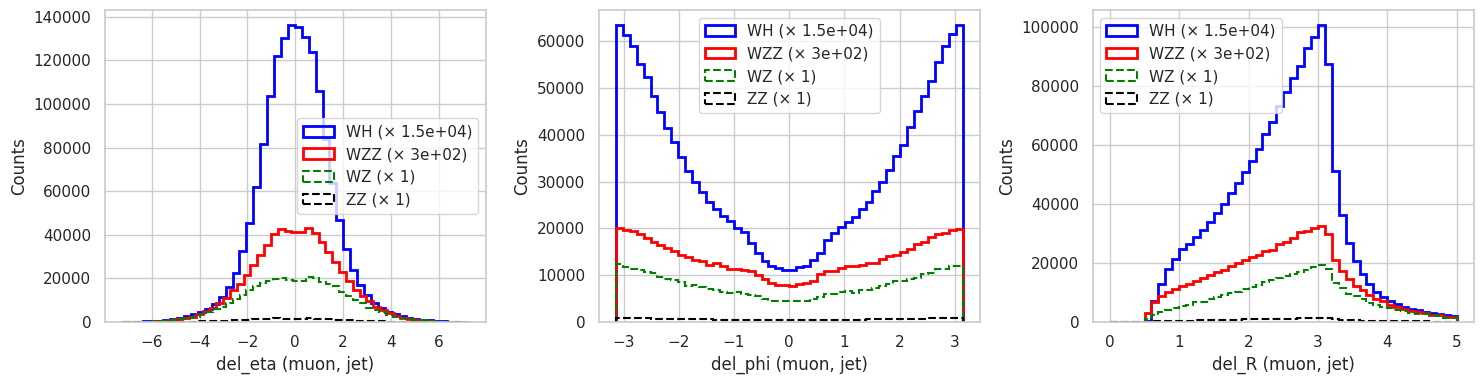

In [8]:
# label mapping
label_map = {0: "WH", 1: "WZZ", 2: "WZ", 3: "ZZ"}
colors = {0: "blue", 1: "red", 2: "green", 3: "black"}

#normaliz factors and multiplicative factors
norm_factors = {
    "WH": 0.0001218 * 15000,
    "WZZ": 0.0081 * 300,
    "WZ": 4.0,
    "ZZ": 0.196
}
multiplicative_factors = {
    "WH": 15000,
    "WZZ": 300,
    "WZ": 1.0,
    "ZZ": 1.0
}

signal_labels = {0, 1}  # WH and WZZ
background_labels = {2, 3}  # WZ and ZZ

# prepare plotting canvas
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# delta phi helper
def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    return (dphi + np.pi) % (2 * np.pi) - np.pi

# loop over all datasets
for label_val, (key, path) in enumerate(file_paths.items()):
    print(f"Loading {key}...")
    events = load_tree(path, branches)

    # muon and jet objects
    events["mu"] = ak.zip({"eta": events.mu_eta, "phi": events.mu_phi})
    events["jet"] = ak.zip({"eta": events.jet_eta, "phi": events.jet_phi})

    # all muon–jet pairs
    mu_jet_pairs = ak.cartesian({"mu": events.mu, "jet": events.jet}, axis=1)

    #three dels
    delta_eta_mu_jet = mu_jet_pairs["mu"].eta - mu_jet_pairs["jet"].eta
    delta_phi_mu_jet = delta_phi(mu_jet_pairs["mu"].phi, mu_jet_pairs["jet"].phi)
    deltaR_mu_jet = np.sqrt(delta_eta_mu_jet**2 + delta_phi_mu_jet**2)

    # flatten to 1D arrays
    all_delta_eta = ak.to_numpy(ak.flatten(delta_eta_mu_jet, axis=None))
    all_delta_phi = ak.to_numpy(ak.flatten(delta_phi_mu_jet, axis=None))
    all_deltaR = ak.to_numpy(ak.flatten(deltaR_mu_jet, axis=None))

    # style + weights
    label_name = label_map[label_val]
    weight = norm_factors[label_name]
    multiplier = multiplicative_factors[label_name]
    display_label = f"{label_name} (× {multiplier:.2g})"
    linestyle = '-' if label_val in signal_labels else '--'
    linewidth = 2 if label_val in signal_labels else 1.5

    # plot
    axes[0].hist(all_delta_eta, bins=50, histtype="step",
                 color=colors[label_val], weights=np.full(len(all_delta_eta), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)
    axes[1].hist(all_delta_phi, bins=50, histtype="step",
                 color=colors[label_val], weights=np.full(len(all_delta_phi), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)
    axes[2].hist(all_deltaR, bins=50, range=(0, 5), histtype="step",
                 color=colors[label_val], weights=np.full(len(all_deltaR), weight),
                 label=display_label, linewidth=linewidth, linestyle=linestyle)

# axis labels and formatting
axes[0].set_xlabel(r"del_eta (muon, jet)")
axes[0].set_ylabel("Counts")
axes[1].set_xlabel(r"del_phi (muon, jet)")
axes[1].set_ylabel("Counts")
axes[2].set_xlabel(r"del_R (muon, jet)")
axes[2].set_ylabel("Counts")

for ax in axes:
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


## Calling Features and Functions, to implement selection cuts and construct features for NN

In [9]:
all_datasets = {
    "WH": signal_data["WH"],
    "WZZ": signal_data["WZZ"],
    "WZ": background_data["WZ"],
    "ZZ": background_data["ZZ"],
}

vector.register_awkward()   #tells vector to automatically interpret awkward arrays of dictionaries

 cuts filter events, so they must be applied while the data is still in the awkward.Array format — before converting to flat pandas DataFrames.

What the nLeptons == 3 cut is doing here:
- counts the total number of leptons before any qualitative cuts (like delR cleaning, pt > 10, |eta| < 2.5).
- selects events that appear to have exactly 3 leptons (muons + electrons).

### Main looper over files that a. implements cuts b. gets a df


In [3]:
dfs = []
label_map = {"WH": 0, "WZZ": 1, "WZ": 2, "ZZ": 3}
lepton_counts = {}

norm_factors = {
    "WH": 0.0001218,
    "WZZ": 0.0081,
    "WZ": 4.0,
    "ZZ": 0.196   
}

for key, path in file_paths.items():
    print(f"Loading {key}...")
    
    events = load_tree(path, branches)

    #aapplying the full cleaning (includes kinematics + delR)
    events_cut = clean_leptons(events, deltaR_cut=0.4, pt_min=10, eta_max=2.5)
    
    nElectrons = ak.num(events_cut.el_pt, axis=1)
    nMuons = ak.num(events_cut.mu_pt, axis=1)     #counter for leptons
    nLeptons = nElectrons + nMuons
    lepton_counts[key] = nLeptons

    events_cut = events_cut[nLeptons == 3] #require exactly 3 leps

    #Extracting features ONLY AFTER MAKING THE CUTS AHA! 3 leptons 
    df = extract_features(events_cut, label_map[key])
    df.dropna(inplace=True)
    
    weighted_events = df.shape[0] * norm_factors[key]
    print(f"{df.shape[0]} raw events, {weighted_events:.3f} weighted events")

    dfs.append(df)

Loading WH...
m_3lep: [ 72.49341875 144.26776621 171.53444794 227.61203909 136.48449483]
MT_lep_MET: [60.40946535223097 17.258141393277878 76.41047809439284 6.264424755857718
 84.64380840235977]
total_event_et: [413.8886547088623 343.1293525695801 210.9979953765869 471.37082290649414
 167.21910667419434]
best_Z_mass_mu: [  57.04573283 -999.         -999.         -999.          112.21065826]
best_Z_mass_el: [-999.           98.53834401   55.30567199  145.36463771 -999.        ]
best_Z_pt_mu: [ 130.43197675 -999.         -999.         -999.           19.46219243]
best_Z_pt_el: [-999.           43.11044843   44.03765913  157.6310237  -999.        ]
del_phi_Z_MET_mu: [-1.983152622722157 1.6666037789550676 -1.4295379170211897
 2.517113303300466 -2.2428769646752986]
del_phi_Z_MET_el: [-1.911982799414073 1.2228377489465223 -2.3077117932138993
 0.22024577388185665 2.183680628892507]
pt_3lepsys: [197.08929692  98.8413219   58.61768175 124.08710881  33.76733157]
dphi_met_3lepsys: [-1.93060065357

In [11]:
print(dfs)

[        el_pt_0  el_eta_0  el_phi_0    mu_pt_0  mu_eta_0  mu_phi_0    el_pt_1  \
1     55.669815 -2.352292 -1.288446  66.192032 -1.748275  0.486696  43.205700   
7     36.013947 -0.636111 -0.877571  54.117821  0.176474 -0.537926   3.000000   
10     3.000000  3.000000  3.000000  40.206356 -0.213790 -0.769473   3.000000   
11    44.608295 -0.475117  1.546239   3.000000  3.000000  3.000000  37.021107   
12    30.163681 -1.744947  0.191973  40.456070 -1.011281  0.069842  24.833467   
...         ...       ...       ...        ...       ...       ...        ...   
3972  50.488884 -1.387805 -2.116679  26.615177 -1.687949  0.899591  37.334457   
3976  37.610703  2.226079  0.873448  34.421589  2.006343  1.670371   3.000000   
3978  44.474052  1.330873  1.009441   3.000000  3.000000  3.000000  41.561424   
3979  27.668182 -0.388203 -1.579493  49.611481  1.776419 -2.393440   3.000000   
3980  48.525963  1.932878 -1.427314  31.993587  1.789329  0.236440  18.313040   

      el_eta_1  el_phi_1  

In [12]:
print(df[["m_3lep", "total_event_et", "MT_lep_MET", "best_Z_mass_mu", "best_Z_mass_el", "best_Z_pt_mu", "best_Z_pt_el", "del_phi_Z_MET_mu", "del_phi_Z_MET_el",
          "pt_3lepsys", "dphi_met_3lepsys", "m12", "m23", "m31", "deltaR12", "deltaR23", "deltaR31", "deta12","deta23","deta31","dphi12","dphi23", "dphi31", 
          "sphericity", "aplanarity", "Z_MET_par_mu", "Z_MET_perp_mu", "Z_MET_ratio_mu", "Z_MET_diff_mu", "Z_MET_recoil_mu",
          "Z_MET_par_el", "Z_MET_perp_el", "Z_MET_ratio_el", "Z_MET_diff_el", "Z_MET_recoil_el", "del_phi_Z_lep_mu", "del_phi_Z_lep_el"]].isna().sum())

m_3lep              0
total_event_et      0
MT_lep_MET          0
best_Z_mass_mu      0
best_Z_mass_el      0
best_Z_pt_mu        0
best_Z_pt_el        0
del_phi_Z_MET_mu    0
del_phi_Z_MET_el    0
pt_3lepsys          0
dphi_met_3lepsys    0
m12                 0
m23                 0
m31                 0
deltaR12            0
deltaR23            0
deltaR31            0
deta12              0
deta23              0
deta31              0
dphi12              0
dphi23              0
dphi31              0
sphericity          0
aplanarity          0
Z_MET_par_mu        0
Z_MET_perp_mu       0
Z_MET_ratio_mu      0
Z_MET_diff_mu       0
Z_MET_recoil_mu     0
Z_MET_par_el        0
Z_MET_perp_el       0
Z_MET_ratio_el      0
Z_MET_diff_el       0
Z_MET_recoil_el     0
del_phi_Z_lep_mu    0
del_phi_Z_lep_el    0
dtype: int64


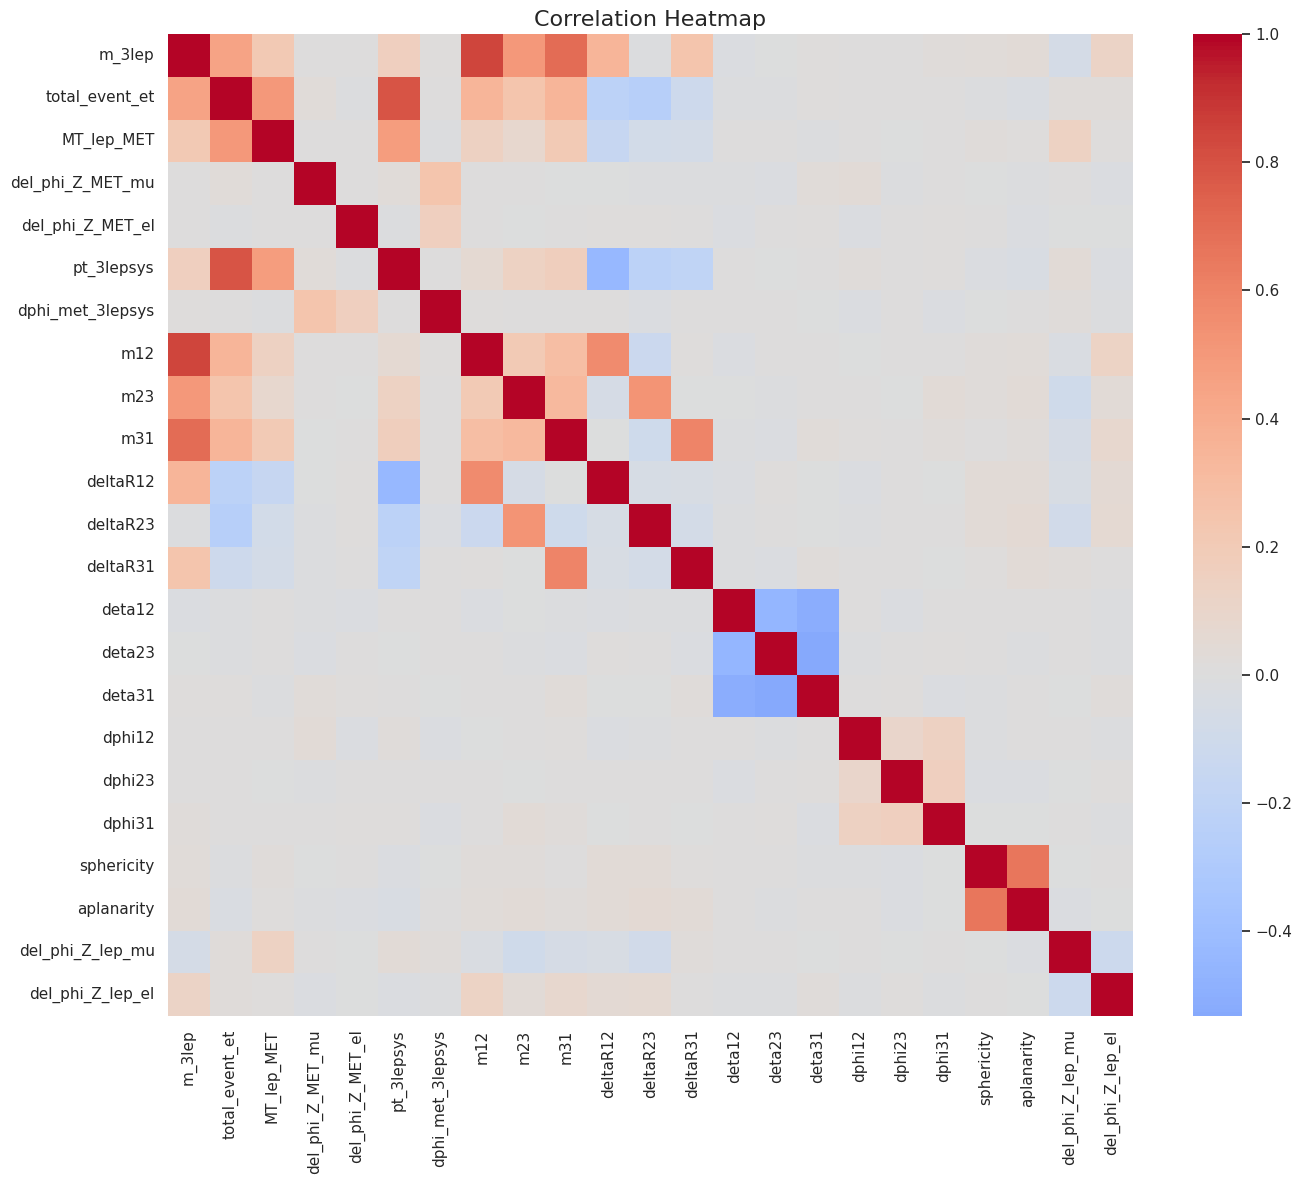

In [13]:
#for correlation map
#LOW CORRELATION VARIABLES

import seaborn as sns
features = [
    "m_3lep", "total_event_et", "MT_lep_MET", "del_phi_Z_MET_mu", "del_phi_Z_MET_el",
    "pt_3lepsys", "dphi_met_3lepsys", "m12", "m23", "m31", "deltaR12", "deltaR23", 
    "deltaR31", "deta12","deta23","deta31","dphi12","dphi23", "dphi31", 
    "sphericity", "aplanarity", 
    "del_phi_Z_lep_mu", "del_phi_Z_lep_el"
]

corr = df[features].corr()


plt.figure(figsize=(14, 12))
#sns.clustermap(corr, cmap="coolwarm", center=0)
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, fmt=".2f")
plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.savefig("Feature_Corr_Low.png", dpi=300, bbox_inches='tight')
plt.show()

#if want to see highly correlated featuers
#mask = np.triu(np.ones_like(corr, dtype=bool))
#sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0)

#to cluster correlated features together
#sns.clustermap(corr, cmap="coolwarm", center=0)


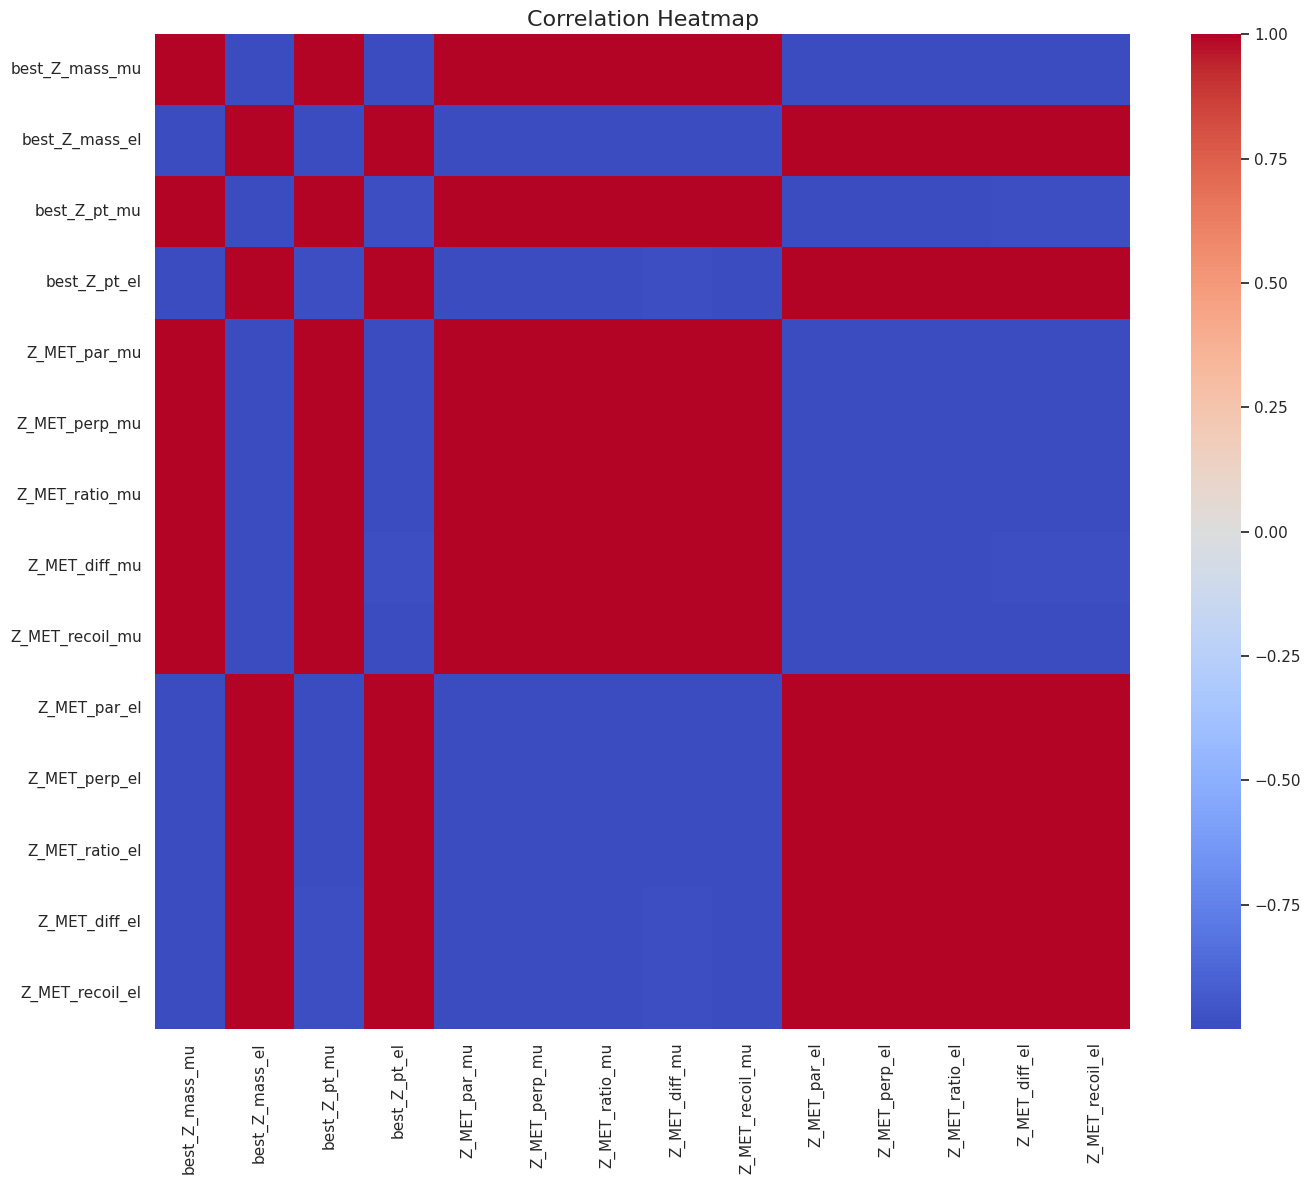

In [14]:
#HIGH CORRELATION VARIABLES
features = [
    "best_Z_mass_mu", "best_Z_mass_el", 
    "best_Z_pt_mu", "best_Z_pt_el", "Z_MET_par_mu", "Z_MET_perp_mu", "Z_MET_ratio_mu", 
    "Z_MET_diff_mu", "Z_MET_recoil_mu", "Z_MET_par_el", "Z_MET_perp_el", 
    "Z_MET_ratio_el", "Z_MET_diff_el", "Z_MET_recoil_el", 
]

corr = df[features].corr()


plt.figure(figsize=(14, 12))
#sns.clustermap(corr, cmap="coolwarm", center=0)
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, fmt=".2f")
plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.savefig("Feature_Corr_High.png", dpi=300, bbox_inches='tight')
plt.show()

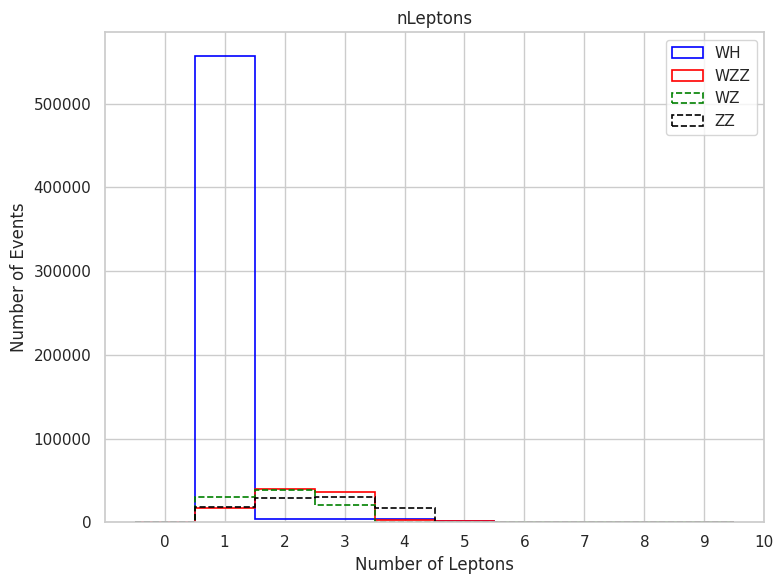

In [15]:
signal_colors = {
    "WH": "blue",
    "WZZ": "red",
}

background_colors = {
    "WZ": "green",
    "ZZ": "black",
}

plt.figure(figsize=(8, 6))
bins = np.arange(0, 10 + 1) - 0.5  #Center on integer values

for key, nlep in lepton_counts.items():
    if key in signal_colors:
        color = signal_colors[key]
        linestyle = '-'
    else:
        color = background_colors.get(key, 'gray')
        linestyle = '--'
    
    plt.hist(nlep, bins=bins, alpha=1, label=key, histtype='step',
         color=color, linewidth=1.2, linestyle=linestyle)


plt.xlabel("Number of Leptons")
plt.ylabel("Number of Events")
plt.title("nLeptons")
plt.xticks(np.arange(0, 11))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
type(dfs)
print(len(dfs))
print(type(dfs[0]))
print(dfs[0].columns)

4
<class 'pandas.core.frame.DataFrame'>
Index(['el_pt_0', 'el_eta_0', 'el_phi_0', 'mu_pt_0', 'mu_eta_0', 'mu_phi_0',
       'el_pt_1', 'el_eta_1', 'el_phi_1', 'mu_pt_1', 'mu_eta_1', 'mu_phi_1',
       'el_pt_2', 'el_eta_2', 'el_phi_2', 'mu_pt_2', 'mu_eta_2', 'mu_phi_2',
       'jet_pt_0', 'jet_eta_0', 'jet_phi_0', 'jet_pt_1', 'jet_eta_1',
       'jet_phi_1', 'jet_mass_0', 'jet_btag_0', 'MET', 'MET_Phi', 'm_3lep',
       'total_event_et', 'MT_lep_MET', 'best_Z_mass_mu', 'best_Z_mass_el',
       'best_Z_pt_mu', 'best_Z_pt_el', 'del_phi_Z_MET_mu', 'del_phi_Z_MET_el',
       'del_phi_Z_lep_mu', 'del_phi_Z_lep_el', 'pt_3lepsys',
       'dphi_met_3lepsys', 'Z_MET_par_mu', 'Z_MET_perp_mu', 'Z_MET_ratio_mu',
       'Z_MET_diff_mu', 'Z_MET_recoil_mu', 'Z_MET_par_el', 'Z_MET_perp_el',
       'Z_MET_ratio_el', 'Z_MET_diff_el', 'Z_MET_recoil_el', 'm12', 'm23',
       'm31', 'deta12', 'deta23', 'deta31', 'dphi12', 'dphi23', 'dphi31',
       'deltaR12', 'deltaR23', 'deltaR31', 'sphericity', 'aplanar

dfs is a list of 4 DataFrames (one per class). Each individual item in dfs (like dfs[0], dfs[1], ...) is a proper pandas DataFrame and includes a label column already.

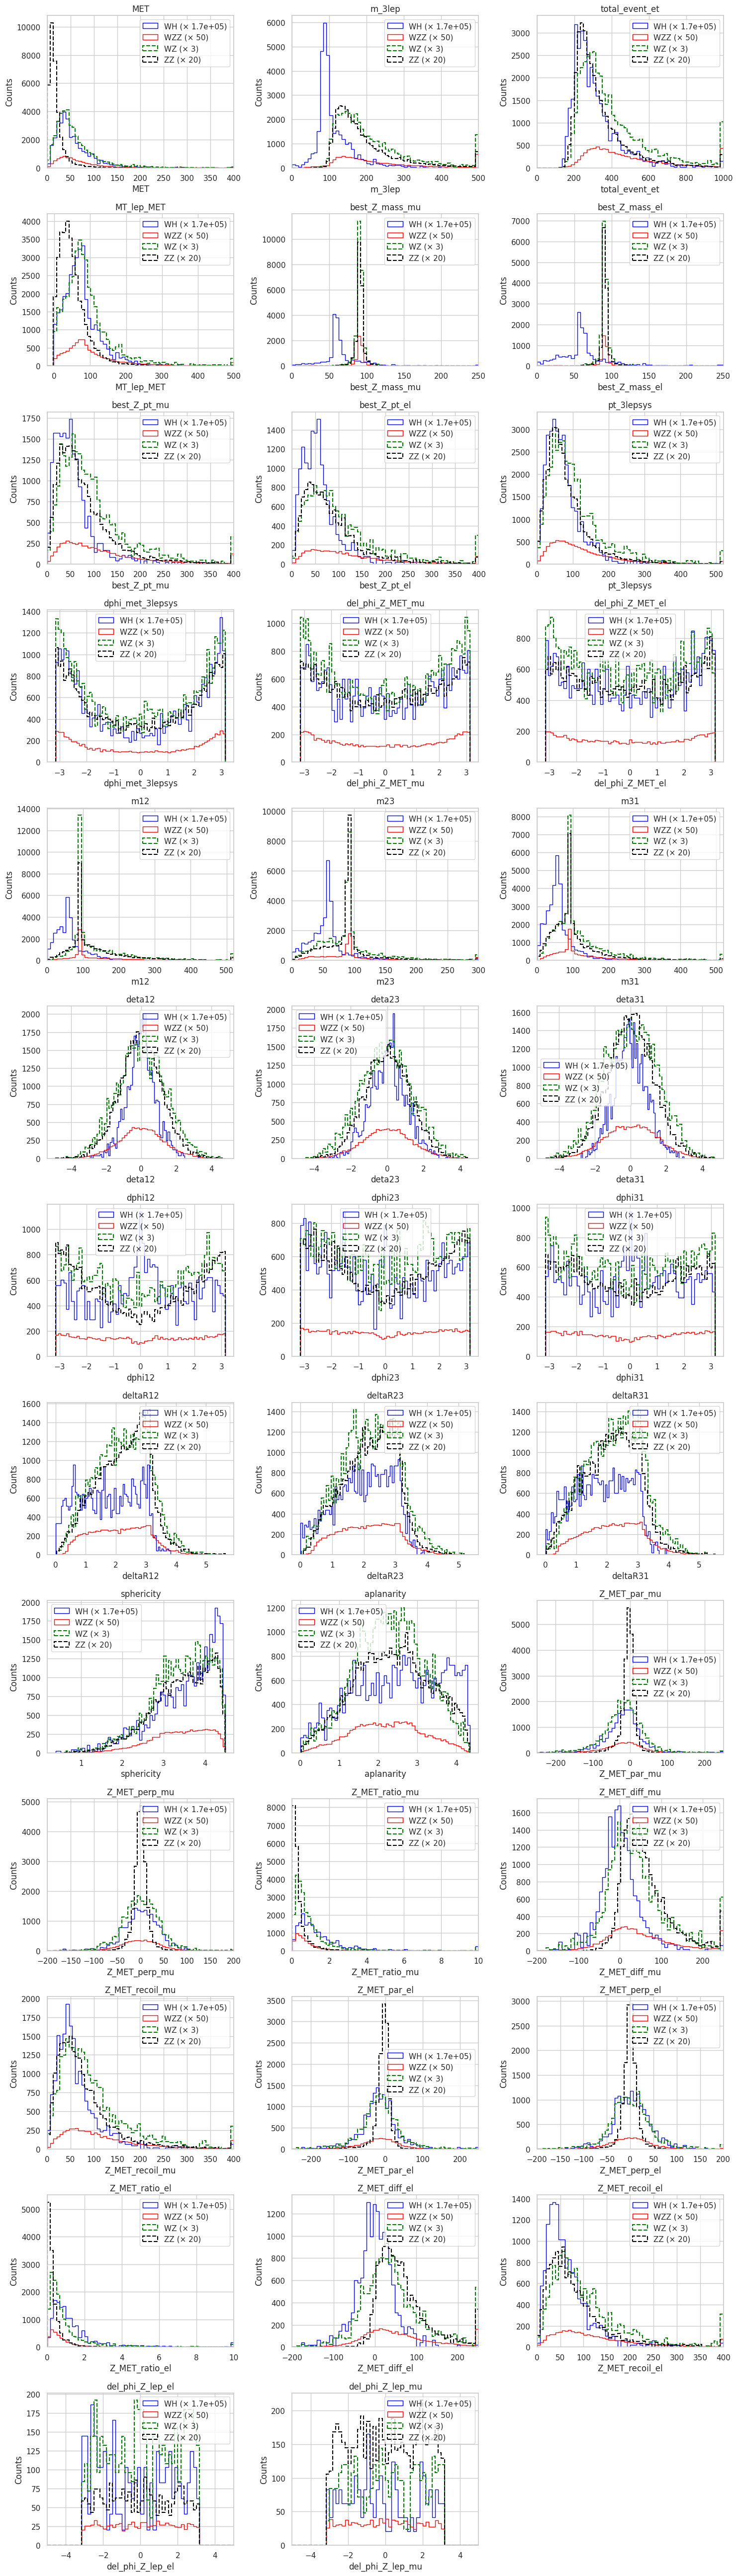

In [17]:

df = pd.concat(dfs, ignore_index=True)

label_map = {0: "WH", 1: "WZZ", 2: "WZ", 3: "ZZ"}
colors = {0: "blue", 1: "red", 2: "green", 3: "black"}

# Normalization factors and multiplicative factors from Part I
norm_factors = {
    "WH": 0.0001218 * 170000,
    "WZZ": 0.0081 * 50,
    "WZ": 4.0*3,
    "ZZ": 0.196 * 20
}

multiplicative_factors = {
    "WH": 170000,
    "WZZ": 50,
    "WZ": 3.0,
    "ZZ": 20
}
x_limits = {
    "MET": (0, 400),
    "m_3lep": (0, 500),
    "total_event_et": (0, 1000),
    "MT_lep_MET": (-20, 500),
    "pt_3lepsys": (0,520),
    "best_Z_mass_mu": (0, 250),
    "best_Z_mass_el": (0, 250),
    "best_Z_pt_mu": (0, 400),
    "best_Z_pt_el": (0, 400),
    "m12":(0,520), 
    "m23":(0,300), 
    "m31":(0,520), 
    #"Z_MET_dphi_mu":(), 
    "Z_MET_par_mu":(-250, 250), 
    "Z_MET_perp_mu":(-200, 200), 
    "Z_MET_ratio_mu": (0, 10), 
    "Z_MET_diff_mu":(-200, 250), 
    "Z_MET_recoil_mu": (0, 400),
    #"Z_MET_dphi_el": (), 
    "Z_MET_par_el":(-250,250), 
    "Z_MET_perp_el":(-200,200), 
    "Z_MET_ratio_el":(0,10), 
    "Z_MET_diff_el":(-200, 250), 
    "Z_MET_recoil_el":(0, 400),
    "del_phi_Z_lep_mu":(-5,5), 
    "del_phi_Z_lep_el":(-5,5)
}

features = ["MET", "m_3lep","total_event_et", "MT_lep_MET",  "best_Z_mass_mu", "best_Z_mass_el", "best_Z_pt_mu", "best_Z_pt_el",
            "pt_3lepsys",  "dphi_met_3lepsys", "del_phi_Z_MET_mu", "del_phi_Z_MET_el",
            "m12", "m23", "m31", "deta12","deta23","deta31","dphi12","dphi23", "dphi31", "deltaR12", "deltaR23", "deltaR31", 
            "sphericity", "aplanarity", "Z_MET_par_mu", "Z_MET_perp_mu", "Z_MET_ratio_mu", "Z_MET_diff_mu", "Z_MET_recoil_mu",
          "Z_MET_par_el", "Z_MET_perp_el", "Z_MET_ratio_el", "Z_MET_diff_el", "Z_MET_recoil_el", "del_phi_Z_lep_el", "del_phi_Z_lep_mu"]

n_features = len(features)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()


signal_labels = {0, 1}  # WH and WZZ
background_labels = {2, 3}  # WZ and ZZ

for i, feature in enumerate(features):
    ax = axes[i]

    #bins for overflow
    if feature in x_limits:
        xmin, xmax = x_limits[feature]
        bins = np.linspace(xmin, xmax, 61)  # 50 bins
    else:
        #other features need a default bin
        bins = 65

    for label_val, label_name in label_map.items():
        subset = df[df["label"] == label_val][feature].dropna()

        #clipping to overflow bin range
        if feature in x_limits:
            subset = subset.clip(upper=x_limits[feature][1])

        weight = norm_factors[label_name]
        multiplier = multiplicative_factors[label_name]
        display_label = f"{label_name} (× {multiplier:.2g})"
        linestyle = '-' if label_val in signal_labels else '--'
        linewidth = 1 if label_val in signal_labels else 1.5

        ax.hist(subset,
                bins=bins,
                weights=np.full(len(subset), weight),
                label=display_label,
                color=colors[label_val],
                linewidth=linewidth,
                linestyle=linestyle,
                histtype='step')

    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel("Counts")
    ax.grid(True)
    ax.legend()

    #xlim for plots
    if feature in x_limits:
        ax.set_xlim(x_limits[feature])

#hiding unused axes
for i in range(len(features), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

##there's a crazy -999 peak for best z candidate mass plots, Q. does that make a difference in classification?
#WH (blue solid line)
#Doesn’t have a peak near 91 GeV — instead, there’s a broad structure at much lower invariant masses.
#This is because WH events in your sample probably don’t contain real Z -> lep lep decays most of the time.
#The “best Z candidate” here is being formed from random lepton pairs, so you get a broad distribution.
#If you want the best Z candidate as a feature without biasing the classifier, you should not cut on the 80–100 GeV “Z window” 
#— otherwise, you’re essentially pre-selecting Z-rich events and throwing away useful shape information that can help discriminate signal/background.

#The shape difference itself is a discriminating feature:

#WH has a broad, low-mass distribution.

#ZZ/WZ/WZZ have a narrow peak at ~91 GeV.

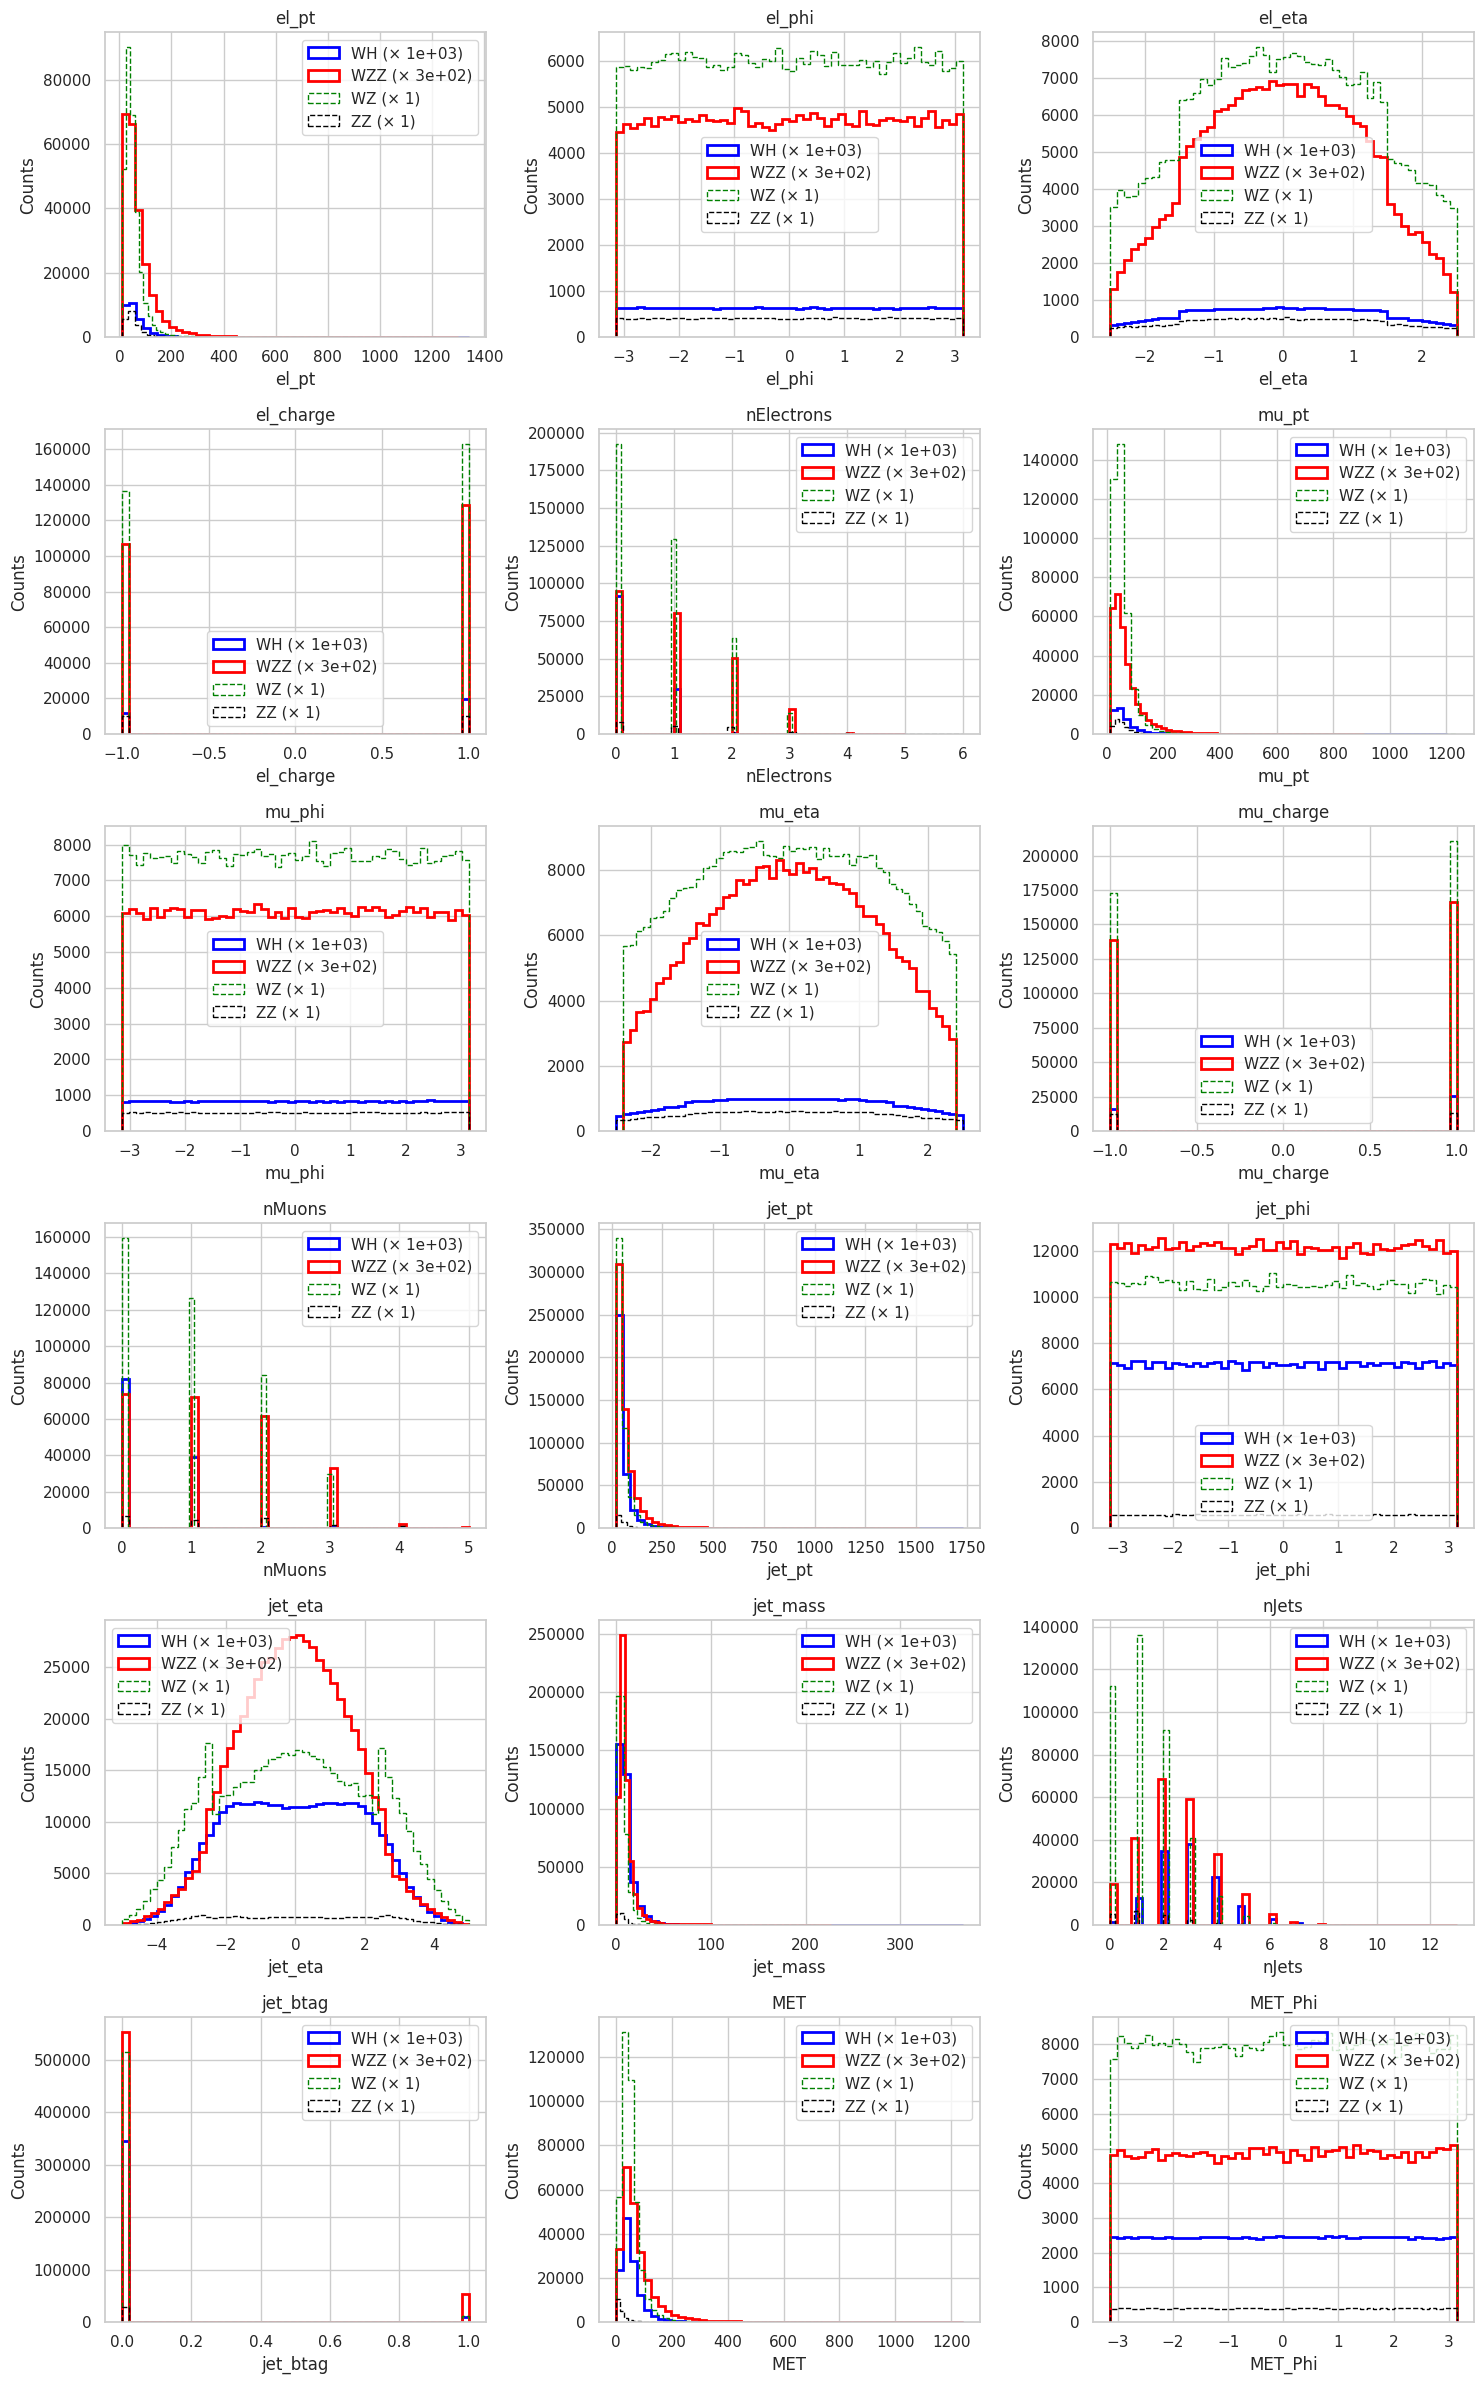

In [18]:
#Plotting right after the cuts are applied, for sanity

norm_factors = {
    "WH": 0.0001218 * 1000,
    "WZZ": 0.0081 * 300,
    "WZ": 4.0,
    "ZZ": 0.196   #Why 4? New value used
}

multiplicative_factors = {
    "WH": 1000,
    "WZZ": 300,
    "WZ": 1.0,
    "ZZ": 1.0
}

n_cols = 3
n_rows = int(np.ceil(len(branches) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))   #plot layout
axes = axes.flatten()


for i, var in enumerate(branches):
    ax = axes[i]             #main loop for plot

    #sig
    for label, arr in signal_data.items():
        values = ak.flatten(arr[var], axis=None)
        weight = norm_factors[label]
        multiplier = multiplicative_factors[label]
        display_label = f"{label} (× {multiplier:.2g})"
        ax.hist(
            values,
            bins=50,
            histtype='step',
            linewidth=2,
            density=False,
            label=display_label,
            linestyle='-',
            color=signal_colors[label],
            weights=[weight] * len(values)
        )

    #backg
    for label, arr in background_data.items():
        values = ak.flatten(arr[var], axis=None)
        weight = norm_factors[label]
        multiplier = multiplicative_factors[label]
        display_label = f"{label} (× {multiplier:.2g})"
        ax.hist(
            values,
            bins=50,
            histtype='step',
            linewidth=1,
            density=False,
            label=display_label,
            linestyle='--',
            color=background_colors[label],
            weights=[weight] * len(values)
        )

    ax.set_xlabel(var)
    ax.set_ylabel("Counts")
    ax.set_title(f"{var}")
    ax.legend()


for j in range(len(branches), len(axes)):   #get rid of unused subplots
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("Combined_normalized_aftercuts.png")
plt.show()

# Neural Network, Construction and Training

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd


df_all = pd.concat(dfs, ignore_index=True)

# dropping features
drop_cols = [
    'mu_eta_1', 'deta31', 'el_pt_2', 'mu_eta_0','el_phi_2','mu_phi_2','mu_phi_0','dphi23',
    'deta12', 'jet_phi_0','mu_phi_1','el_phi_1','el_phi_0', 'el_eta_1', 'deta23', 'sphericity',
    'dphi31','dphi_met_3lepsys', 'dphi12', 'MET_Phi', 'el_eta_2', 'jet_phi_1', 'mu_eta_2',
    "del_phi_Z_MET_mu", "del_phi_Z_MET_el", "deltaR23", "el_eta_0", "jet_eta_0", "jet_eta_1",
    "Z_MET_perp_mu", "Z_MET_ratio_mu", "Z_MET_diff_mu",
    "Z_MET_perp_el", "Z_MET_ratio_el", "Z_MET_diff_el"
]
df_all = df_all.drop(columns=drop_cols)

#features and labels separation
X = df_all.drop(columns=['label']).values
y = df_all['label'].values
n_classes = len(np.unique(y))

print("Features shape:", X.shape)
print("Labels shape:", y.shape)


2025-09-20 08:53:24.111861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758376404.121714 4025036 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758376404.124651 4025036 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758376404.133346 4025036 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758376404.133353 4025036 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758376404.133354 4025036 computation_placer.cc:177] computation placer alr

Features shape: (36822, 30)
Labels shape: (36822,)



🔹 Fold 1/2


/users/dbhandari/WZZtest/proj/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


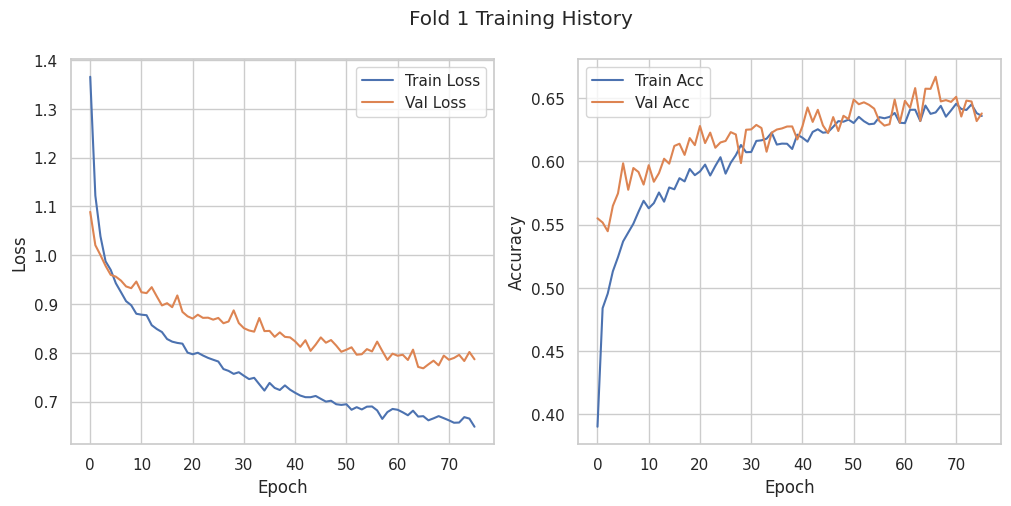

Fold 1 | Val Loss: 0.7681 | Val Acc: 0.6573

🔹 Fold 2/2


/users/dbhandari/WZZtest/proj/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


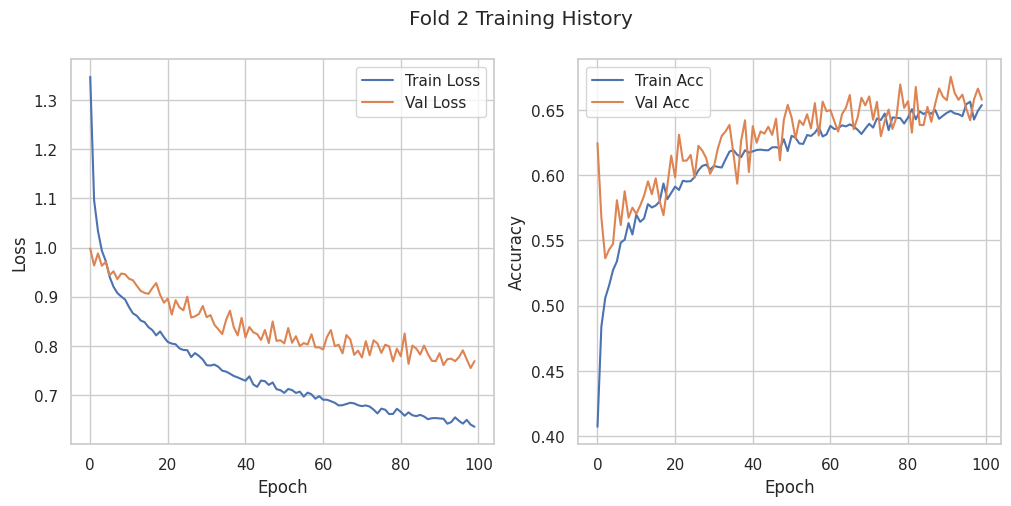

Fold 2 | Val Loss: 0.7551 | Val Acc: 0.6662
576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step

 Cross-validation results:
Validation accuracies per fold: [0.6573244333267212, 0.666232168674469]
Mean accuracy: 0.6617783010005951
Std accuracy: 0.004453867673873901


In [27]:

#even and odd splits based on the number
even_idx = np.arange(len(X))[::2]
odd_idx = np.arange(len(X))[1::2]

splits = [(even_idx, odd_idx), (odd_idx, even_idx)]  # (train_idx, val_idx)

all_scores = []
fold = 1
final_y_true, final_y_pred = None, None  # placeholders
for train_idx, val_idx in splits:
    print(f"\n🔹 Fold {fold}/2")

    #train/val setup
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    #scale for each
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    #one-hot encode
    y_train_cat = to_categorical(y_train, num_classes=n_classes)
    y_val_cat = to_categorical(y_val, num_classes=n_classes)

    #class weights for each
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    cw = dict(zip(np.unique(y_train), class_weights))

    #model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(n_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train_scaled, y_train_cat,
        epochs=100,
        batch_size=128,
        validation_data=(X_val_scaled, y_val_cat),
        class_weight=cw,
        callbacks=[early_stop],
        verbose=0
    )

    #plotting training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

    plt.suptitle(f"Fold {fold} Training History")
    plt.show()

    #eval
    score = model.evaluate(X_val_scaled, y_val_cat, verbose=0)
    print(f"Fold {fold} | Val Loss: {score[0]:.4f} | Val Acc: {score[1]:.4f}")
    all_scores.append(score[1])

    # save the last fold's truth/predictions
    if fold == 2:  # final fold
        final_y_true = y_val
        final_y_pred = np.argmax(model.predict(X_val_scaled), axis=1)

    fold += 1

#results
print("\n Cross-validation results:")
print("Validation accuracies per fold:", all_scores)
print("Mean accuracy:", np.mean(all_scores))
print("Std accuracy:", np.std(all_scores))


Train: (25775, 30) (25775,)
Validation: (5523, 30) (5523,)
Test: (5524, 30) (5524,)


In [28]:
#archi saver, here it only saves the final fold, might need to change.

model_json = model.to_json()
with open("3lepNNmodel_2_fold_cross_validation.json", "w") as json_file:
    json_file.write(model_json)

#saving weights
model.save_weights("3lepNNmodel_2_fold_cross_validation.weights.h5")

#saving model and the weights

In [29]:
from tensorflow.keras.models import model_from_json

#load archi back
with open("3lepNNmodel_2_fold_cross_validation.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

#load weights back
loaded_model.load_weights("3lepNNmodel_2_fold_cross_validation.weights.h5")

#just compiling before using it
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
class_names = ["WH", "WZZ", "WZ", "ZZ"]

#predictions
y_val_pred_proba = model.predict(X_val_scaled)  # probabilities
y_val_pred = np.argmax(y_val_pred_proba, axis=1)

# ROC + AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_cat[:, i], y_val_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#macro-average AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

#cm
cm = confusion_matrix(y_val, y_val_pred)


576/576 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step


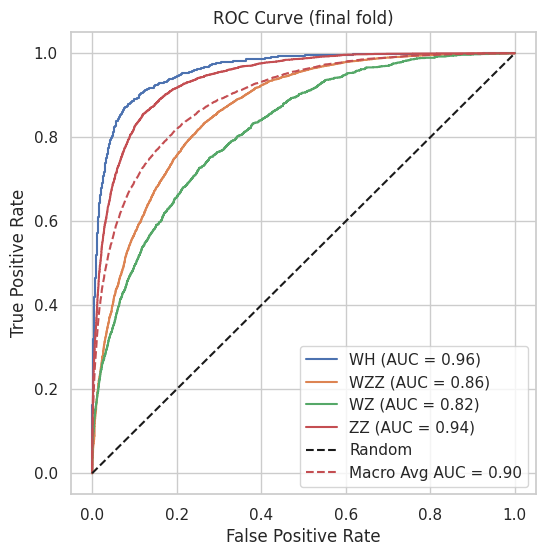

In [31]:
plt.figure(figsize=(6, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.plot(all_fpr, mean_tpr, 'r--', label=f'Macro Avg AUC = {roc_auc["macro"]:.2f}')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (final fold)")
plt.legend()
plt.show()


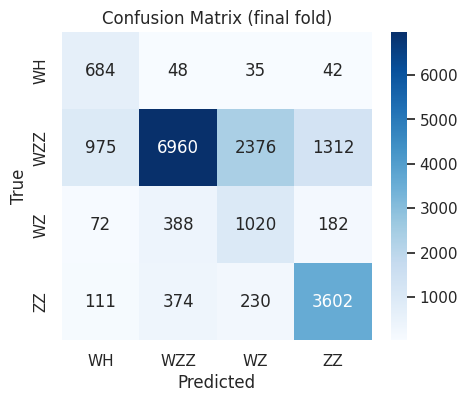

In [32]:
# --- Confusion Matrices for the final fold ---
cm = confusion_matrix(final_y_true, final_y_pred)

# raw confusion matrix heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (final fold)")
plt.show()

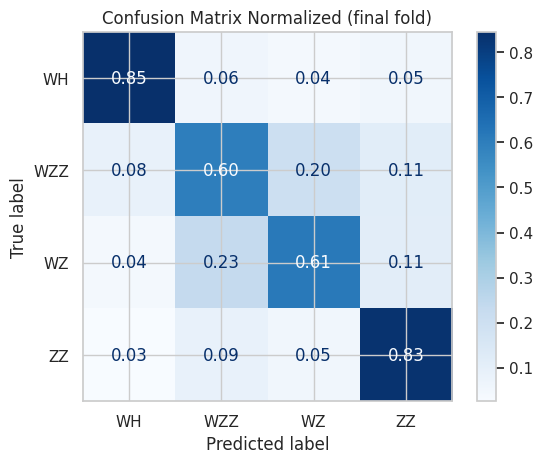

In [33]:
# normalized confusion matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                                   display_labels=class_names)
disp_norm.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix Normalized (final fold)")
plt.show()


🔹 Fold 1/2


/users/dbhandari/WZZtest/proj/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 | Val Loss: 0.8177 | Val Acc: 0.6430


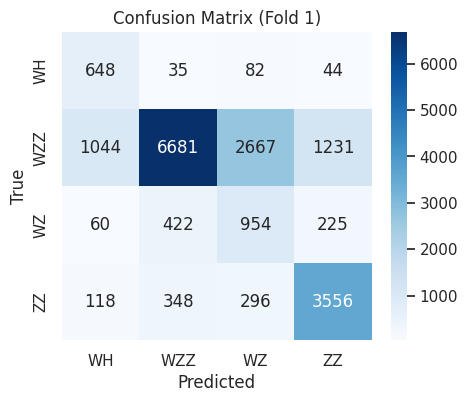

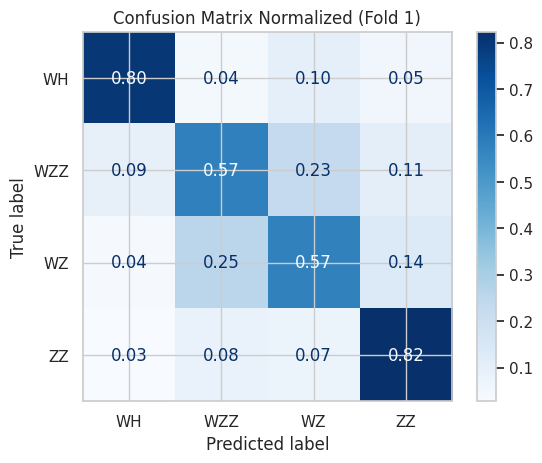

Asimov Z @ 320 fb^-1: WZZ:1.54 | WH:0.79

🔹 Fold 2/2


/users/dbhandari/WZZtest/proj/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2 | Val Loss: 0.7690 | Val Acc: 0.6668


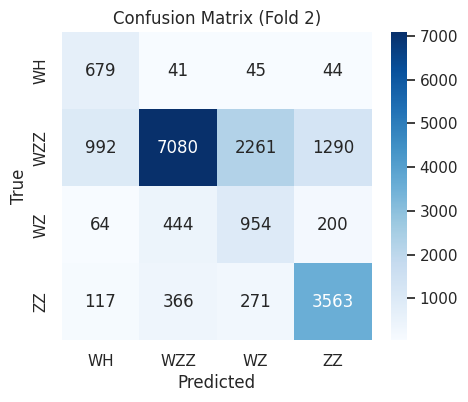

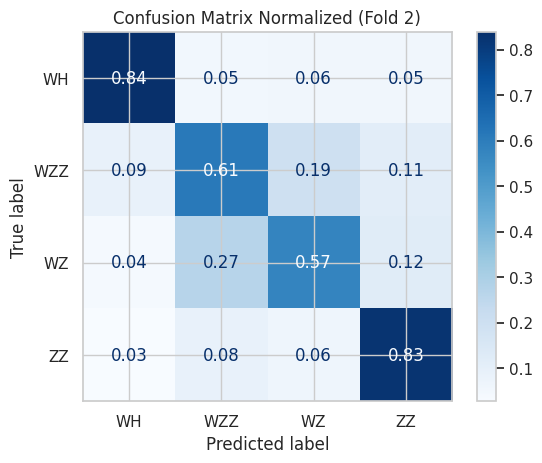

Asimov Z @ 320 fb^-1: WZZ:1.60 | WH:0.80

Cross-validation (2-fold) results:
Validation accuracies per fold: [0.6430394649505615, 0.6667752861976624]
Mean accuracy: 0.6549073755741119
Std accuracy: 0.011867910623550415

Asimov Z per class (mean ± std):
  WH: 0.80 ± 0.01
  WZZ: 1.57 ± 0.03
  WZ: 1369.10 ± 7.91
  ZZ: 68.45 ± 1.91


In [34]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


# asimov sig func
def asimov_Z(s, b, eps=1e-12):
    s = float(s); b = float(b)
    if s <= 0:
        return 0.0
    if b <= 0:
        return np.sqrt(2.0*s)
    return np.sqrt(2.0 * ((s + b) * np.log(1.0 + s / (b + eps)) - s))

def asimov_ovr_from_softmax(y_true, y_pred_proba, class_names, xsec_fb, lumi_fb):
    y_true = np.asarray(y_true)
    y_pred = np.argmax(y_pred_proba, axis=1)
    n_classes = len(class_names)

    N_per_cls = {i: int(np.sum(y_true == i)) for i in range(n_classes)}

    selected_as = {
        c: {i: int(np.sum((y_true == i) & (y_pred == c))) for i in range(n_classes)}
        for c in range(n_classes)
    }

    Z = {}
    for c, cname in enumerate(class_names):
        Nc = N_per_cls[c]
        tp = selected_as[c][c]
        eps_s = tp / Nc if Nc > 0 else 0.0

        eps_b_per_k = {}
        for k in range(n_classes):
            if k == c:
                continue
            Nk = N_per_cls[k]
            fp_k = selected_as[c][k]
            eps_b_per_k[k] = fp_k / Nk if Nk > 0 else 0.0

        S = xsec_fb[cname] * lumi_fb * eps_s
        B = sum(xsec_fb[class_names[k]] * lumi_fb * eps_b_per_k[k]
                for k in range(n_classes) if k != c)

        Z[cname] = asimov_Z(S, B)
    return Z


# setting up
class_names = ["WH", "WZZ", "WZ", "ZZ"]

xsec_fb = {
    "WH": 0.379,
    "WZZ": 2.7,
    "WZ": 1250.0,
    "ZZ": 61.56,
}

ref_lumi = 320.0

#features/labels
X = df_all.drop(columns=['label']).values
y = df_all['label'].values
n_classes = len(np.unique(y))

#two-fold split: even vs odd indices
even_idx = np.arange(len(X))[::2]
odd_idx = np.arange(len(X))[1::2]
splits = [(even_idx, odd_idx), (odd_idx, even_idx)]  # (train_idx, val_idx)

fold = 1
all_scores = []
all_Z = {c: [] for c in class_names}

for train_idx, val_idx in splits:
    print(f"\n🔹 Fold {fold}/2")

    #train/val split
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    #scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    #one-hot
    y_train_cat = to_categorical(y_train, num_classes=n_classes)
    y_val_cat = to_categorical(y_val, num_classes=n_classes)

    #class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    cw = dict(zip(np.unique(y_train), class_weights))

    #model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    #early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    #train!
    model.fit(
        X_train_scaled, y_train_cat,
        epochs=100,
        batch_size=128,
        validation_data=(X_val_scaled, y_val_cat),
        class_weight=cw,
        callbacks=[early_stop],
        verbose=0
    )

    #eval accuracy
    score = model.evaluate(X_val_scaled, y_val_cat, verbose=0)
    print(f"Fold {fold} | Val Loss: {score[0]:.4f} | Val Acc: {score[1]:.4f}")
    all_scores.append(score[1])

    #make prediction
    y_pred_proba = model.predict(X_val_scaled, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)

    #conf matrices
    cm = confusion_matrix(y_val, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Fold {fold})")
    plt.show()

    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm,
                                       display_labels=class_names)
    disp_norm.plot(cmap="Blues", values_format=".2f")
    plt.title(f"Confusion Matrix Normalized (Fold {fold})")
    plt.show()

    #asimov Z
    Z_ref = asimov_ovr_from_softmax(y_val, y_pred_proba, class_names, xsec_fb, ref_lumi)
    for cname in class_names:
        all_Z[cname].append(Z_ref[cname])
    print(f"Asimov Z @ {ref_lumi:.0f} fb^-1: " +
          " | ".join([f"{c}:{Z_ref[c]:.2f}" for c in ["WZZ", "WH"]]))

    fold += 1


#results
print("\nCross-validation (2-fold) results:")
print("Validation accuracies per fold:", all_scores)
print("Mean accuracy:", np.mean(all_scores))
print("Std accuracy:", np.std(all_scores))

print("\nAsimov Z per class (mean ± std):")
for cname in class_names:
    print(f"  {cname}: {np.mean(all_Z[cname]):.2f} ± {np.std(all_Z[cname]):.2f}")


In [36]:
#remove some features maybe based on size of colors for different classes. what to give priority to.

# How Shape Differences in Feature Plots Relate to Multi-Class Classification Performance
1. Peaks and Shape Differences

If two classes have well-separated peaks (e.g., WH events peak at a higher invariant mass than ZZ), then this feature alone carries strong discriminating power.

If their shapes overlap heavily, the feature is less useful by itself.

Larger differences in position/width of peaks → more useful for classification.

2. Multi-Class Case

In multi-class classification (e.g., WH, WZZ, WZ, ZZ):

Some features clearly separate one class from the rest.

Some distinguish pairs of classes.

Others contribute little on their own but still add information when combined with other features.

3. Correlations Matter

A feature that looks weak in 1D can become powerful in combination with others.

Example:

mZ
m
Z
	​

 candidate alone looks similar for WZ and ZZ.

Adding lepton 
pT
p
T
	​

 or 
ΔR
ΔR between jets makes the classes separable in higher-dimensional space.

This is why neural networks and boosted trees outperform simple cut-based methods.

4. Performance Connection

Features with large shape differences → higher importance in the model (entropy/Gini reduction in XGBoost, large SHAP values).

Features with overlapping shapes → lower importance (unless correlations save them).

If all features overlap strongly → classifier struggles (low accuracy, flat ROC curves).

If a few features stand out → classifier performance improves significantly.

5. Physics Angle

The shifted Z candidate peak in WH vs. ZZ/WZ isn’t an artifact — it’s a real physics handle.

It reflects different kinematics of the Z boson depending on whether it comes from Higgs → ZZ or from direct WZ/ZZ production.

Classifiers exploit such differences to separate processes.

Other physics handles:

MET distributions

Jet multiplicities

Angular separations